In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv('Downloads/DailyDelhiClimate.csv')
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1571,2017-04-20,34.500000,27.500000,5.562500,998.625000
1572,2017-04-21,34.250000,39.375000,6.962500,999.875000
1573,2017-04-22,32.900000,40.900000,8.890000,1001.600000
1574,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [5]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


In [7]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [9]:
df['date'] =pd.to_datetime(df['date'])
df.dtypes


date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object

In [11]:
df.isnull().any()

date            False
meantemp        False
humidity        False
wind_speed      False
meanpressure    False
dtype: bool

In [13]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [15]:
df.duplicated().sum()

0

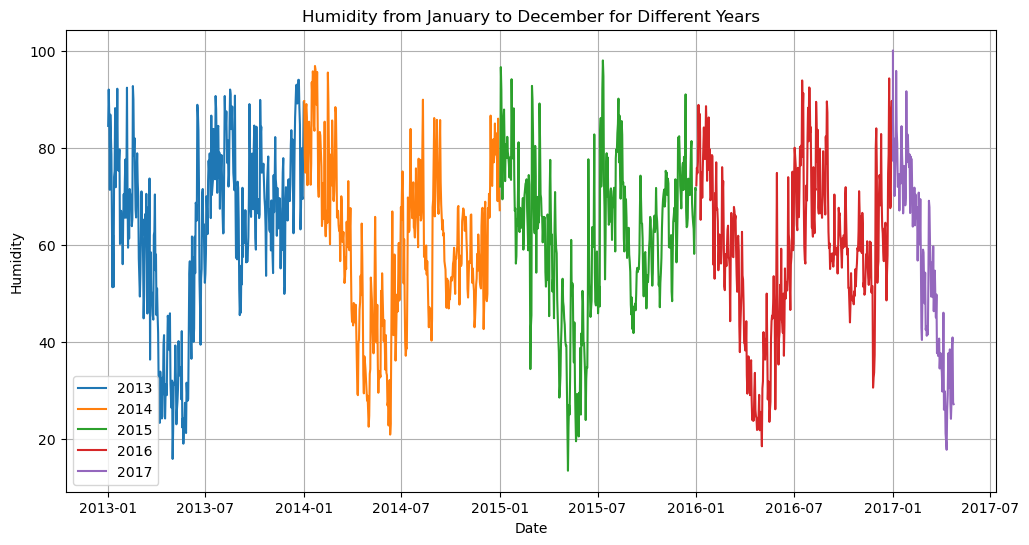

In [17]:
df_year = df[df['date'].dt.month.isin(range(1, 13))]
plt.figure(figsize=(12,6))

for year, group in df_year.groupby(df_year['date'].dt.year):
    plt.plot(group['date'], group['humidity'], label=str(year))

plt.xlabel("Date")
plt.ylabel("Humidity")
plt.title("Humidity from January to December for Different Years")
plt.legend()
plt.grid(True)
plt.show()


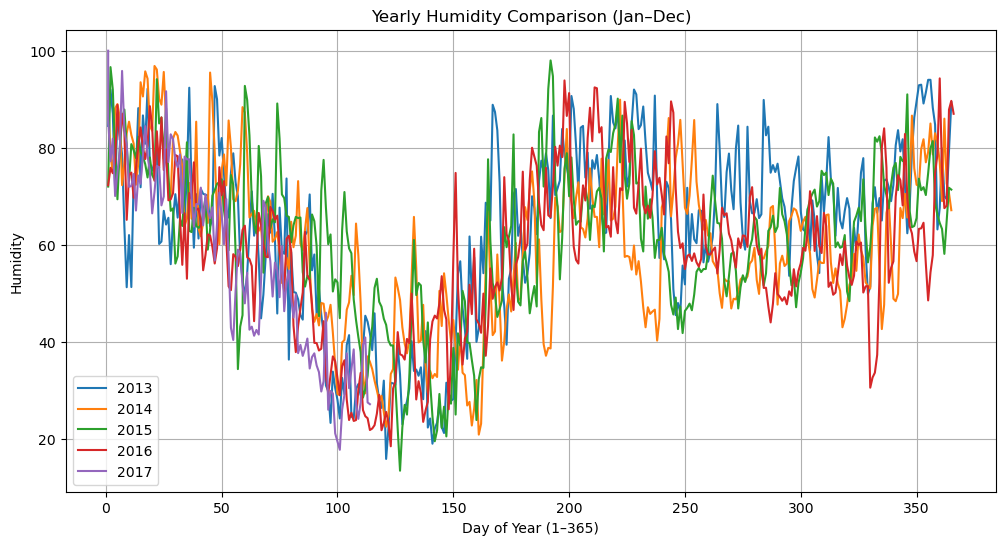

In [18]:
df_year['day_of_year'] = df_year['date'].dt.dayofyear

plt.figure(figsize=(12,6))

for year, group in df_year.groupby(df_year['date'].dt.year):
    plt.plot(group['day_of_year'], group['humidity'], label=str(year))

plt.xlabel("Day of Year (1–365)")
plt.ylabel("Humidity")
plt.title("Yearly Humidity Comparison (Jan–Dec)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
df1 = df[['date','humidity']]
df1

,date,humidity
0,2013-01-01,84.500000
1,2013-01-02,92.000000
2,2013-01-03,87.000000
3,2013-01-04,71.333333
4,2013-01-05,86.833333
...,...,...
1571,2017-04-20,27.500000
1572,2017-04-21,39.375000
1573,2017-04-22,40.900000
1574,2017-04-23,27.500000


In [21]:
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.month
df1

C:\Users\vedan\AppData\Local\Temp\ipykernel_19940\3546841474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['year'] = df1['date'].dt.year
C:\Users\vedan\AppData\Local\Temp\ipykernel_19940\3546841474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['month'] = df1['date'].dt.month


,date,humidity,year,month
0,2013-01-01,84.500000,2013,1
1,2013-01-02,92.000000,2013,1
2,2013-01-03,87.000000,2013,1
3,2013-01-04,71.333333,2013,1
4,2013-01-05,86.833333,2013,1
...,...,...,...,...
1571,2017-04-20,27.500000,2017,4
1572,2017-04-21,39.375000,2017,4
1573,2017-04-22,40.900000,2017,4
1574,2017-04-23,27.500000,2017,4


In [22]:
df_month = df1.groupby(['year', 'month'])['humidity'].mean().reset_index()
df_month

,year,month,humidity
0,2013,1,73.028802
1,2013,2,71.938563
2,2013,3,57.417243
3,2013,4,34.612103
4,2013,5,28.938249
5,2013,6,58.758135
6,2013,7,74.873387
7,2013,8,76.757104
8,2013,9,64.552738
9,2013,10,70.255607


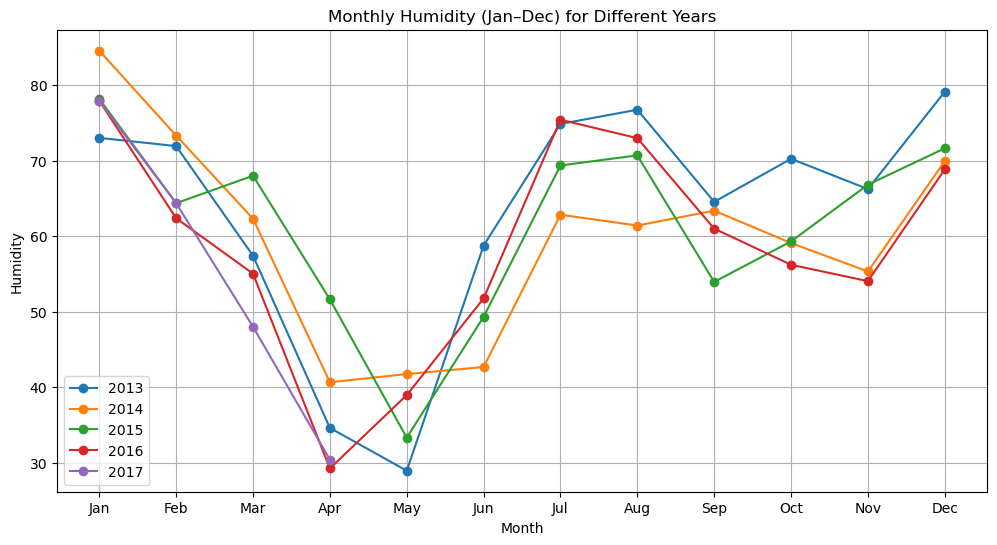

In [27]:
plt.figure(figsize=(12,6))

for year, group in df_month.groupby('year'):
    plt.plot(group['month'], group['humidity'], marker='o', label=str(year))

plt.xticks(range(1,13), 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel("Month")
plt.ylabel("Humidity")
plt.title("Monthly Humidity (Jan–Dec) for Different Years")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
df2 = df[df['date'].dt.year != 2017]
df2

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1456,2016-12-27,16.850000,67.550000,8.335000,1017.200000
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [29]:
df2.set_index('date',inplace = True)
df2

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-27,16.850000,67.550000,8.335000,1017.200000
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762


In [33]:
result = adfuller(df2['humidity'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -3.7375382997902316
p-value: 0.0036150791308485566
Critical Values:
   1%: -3.4348835326305642
   5%: -2.863542248636555
   10%: -2.5678359819686065


As the p value is less than 0.05, the data is stationary

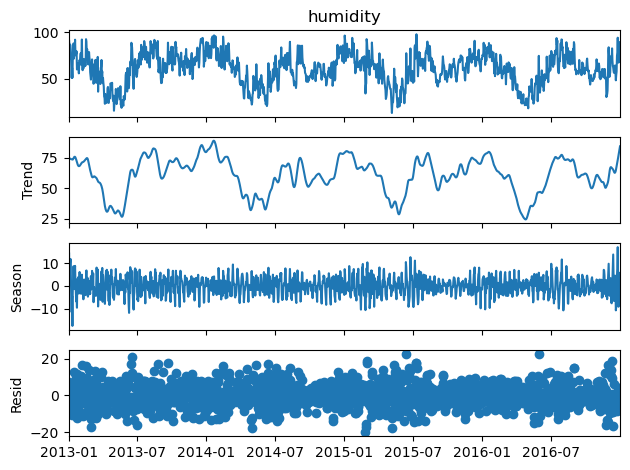

In [38]:
stl = STL(df2['humidity'], period =12)
res = stl.fit()
fig = res.plot()

In [40]:
split_point = int(len(df) * 0.8)
train_data = df2.iloc[:split_point]
test_data = df2.iloc[split_point:]

print(f"Original series length: {len(df)}")
print(f"Train set length (Date split): {len(train_data)}")
print(f"Test set length (Date split): {len(test_data)}")

Original series length: 1576
Train set length (Date split): 1260
Test set length (Date split): 201


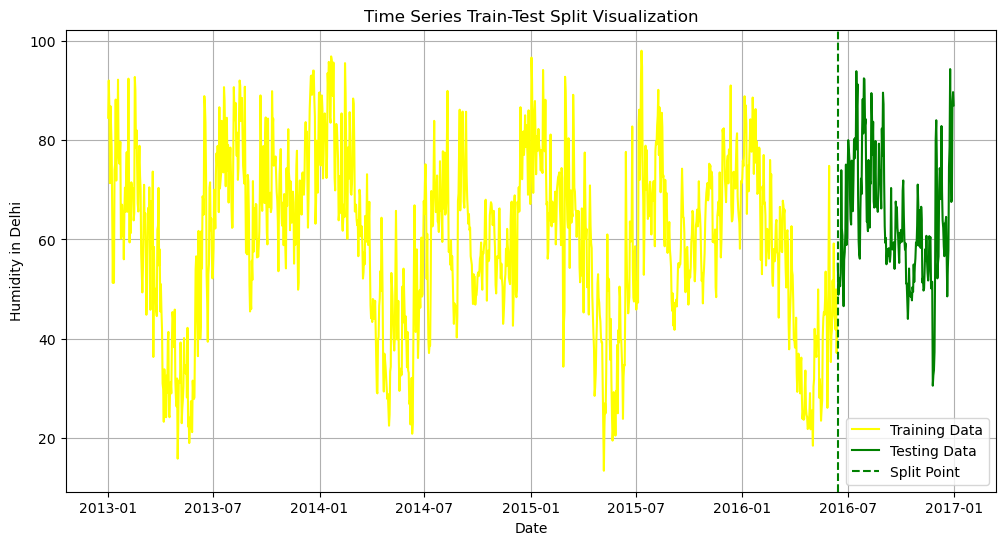

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['humidity'], label='Training Data', color='yellow')
plt.plot(test_data.index, test_data['humidity'], label='Testing Data', color='green')
plt.axvline(x=test_data.index[0], color='green', linestyle='--', label='Split Point')
plt.title('Time Series Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Humidity in Delhi')
plt.legend()
plt.grid(True)
plt.show()

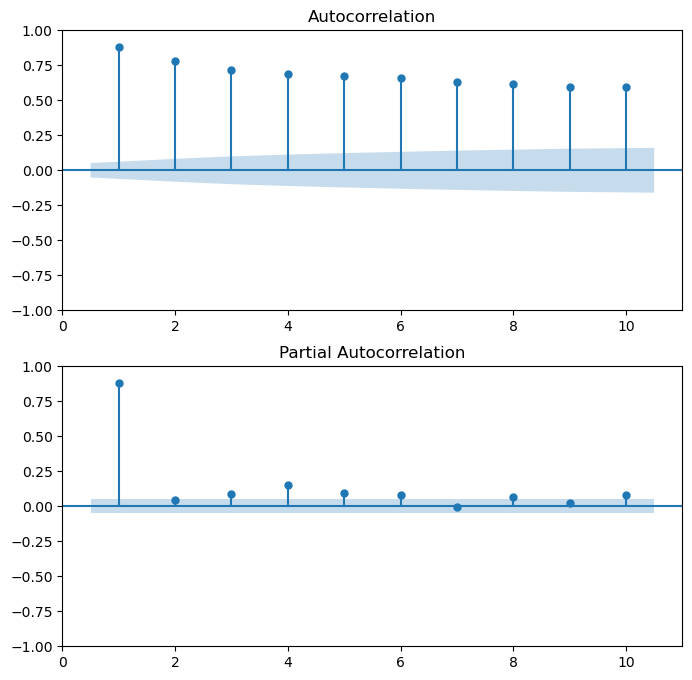

In [44]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(df2['humidity'], lags = 10,zero =False, ax = ax1)
plot_pacf(df2['humidity'], lags = 10,zero =False, ax = ax2)
plt.show()

p = 1, d = 0, q = 0

In [67]:
model = SARIMAX(
    train_data['humidity'],
    exog=None,
    order=(1,0,0),
    seasonal_order=(1,0,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

C:\Users\vedan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\vedan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [69]:
forecast = results.forecast(steps=len(test_data))
forecast

2016-06-14    42.764189
2016-06-15    42.477770
2016-06-16    42.111060
2016-06-17    41.922868
2016-06-18    41.407606
                ...    
2016-12-27     6.616639
2016-12-28     6.553728
2016-12-29     6.491416
2016-12-30     6.429696
2016-12-31     6.368563
Freq: D, Name: predicted_mean, Length: 201, dtype: float64

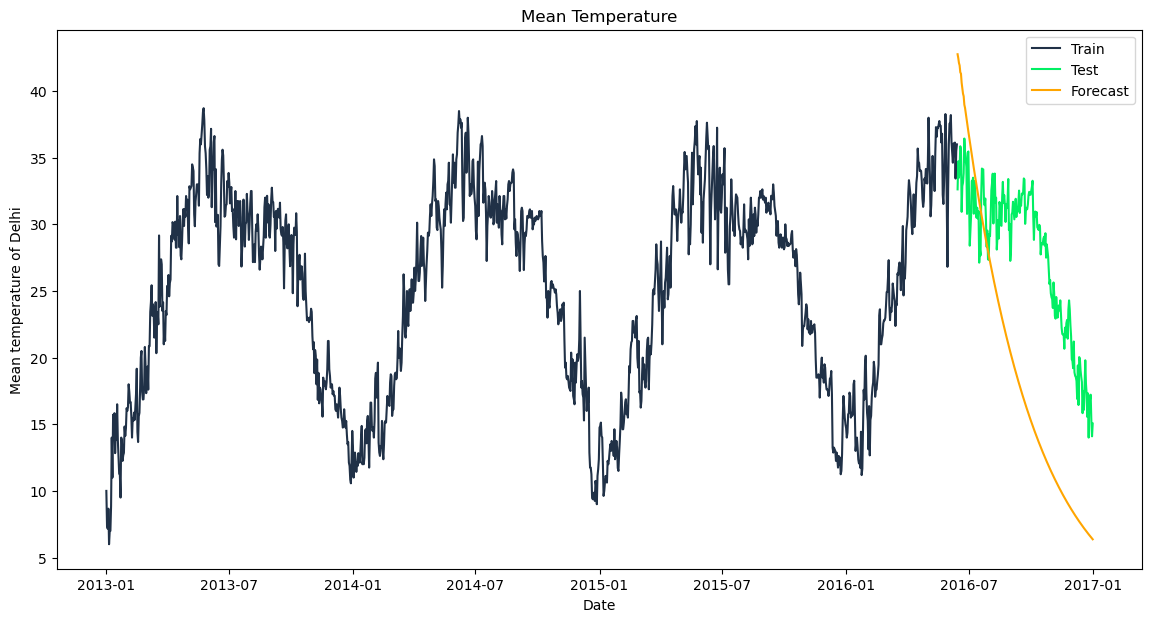

In [71]:
plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data["meantemp"], label='Train', color='#203147')
plt.plot(test_data.index, test_data["meantemp"], label='Test', color='#01ef63')
plt.plot(test_data.index, forecast, label='Forecast', color='orange')
plt.title('Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean temperature of Delhi')
plt.legend()
plt.show()

In [73]:
mse = mean_squared_error(test_data['meantemp'], forecast)
print("MSE:", mse)
mae = mean_absolute_error(test_data['meantemp'], forecast)
print("MAE:", mae)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
mape = np.mean(np.abs((test_data['meantemp'] - forecast) / test_data['meantemp'])) * 100
print("MAPE:", mape, "%")


MSE: 124.3044868623238
MAE: 10.063023799457085
RMSE: 11.149192206717212
MAPE: 38.79248547002086 %
